# EDM Implementation of climate-vegetation time series in Python

## pyEDM documentation here: https://github.com/SugiharaLab/pyEDM/blob/master/doc/pyEDM.pdf

* E = data dimension
* Tp = prediction interval
* knn = number nearest neighbors
* tau = embedding delay
* theta = Smap localization


In [1]:
%%html

<style>
    .jp-OutputArea-child {
        display: inline-block;
    }
</style>

In [2]:
from pyEDM import *
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import matplotlib as mpl
import statsmodels.api as sm
import matplotlib.animation as animation
import mpl_toolkits.mplot3d.axes3d as p3
import cycler
import seaborn as sns
from scipy.stats import spearmanr

# Examples 

EmbedDimension( dataFrame = sampleData["TentMap"], lib = "1 100", pred = "201 500", columns = "TentMap", target = "TentMap") 



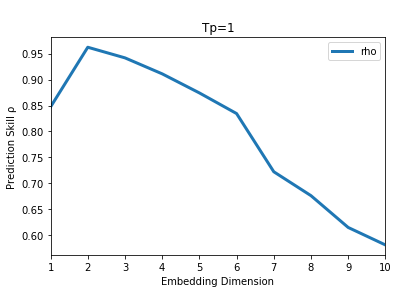

PredictInterval( dataFrame = sampleData["TentMap"], lib = "1 100", pred = "201 500", E = 2, columns = "TentMap", target = "TentMap") 



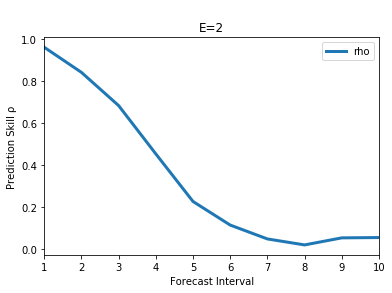

PredictNonlinear( dataFrame = sampleData["TentMapNoise"], lib = "1 100", pred = "201 500", E = 2, columns = "TentMap", target = "TentMap" ) 



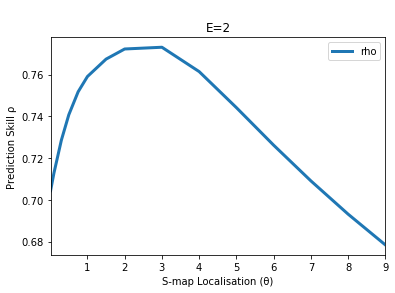

Simplex( dataFrame = sampleData["block_3sp"], lib = "1 99", pred = "100 195",  E = 3, embedded = True, showPlot = True, const_pred = True, columns="x_t y_t z_t", target="x_t") 



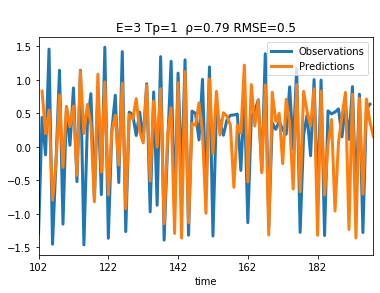

Simplex( dataFrame = sampleData["block_3sp"], lib = "1 99", pred = "105 190",  E = 3, showPlot = True, const_pred = True, columns = "x_t", target = "x_t") 



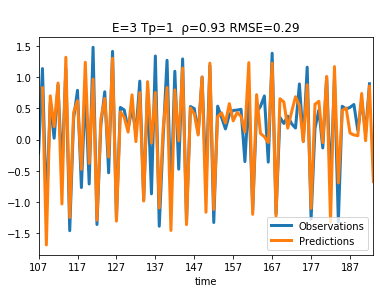

Multiview( dataFrame = sampleData["block_3sp"], lib = "1 99", pred = "105 190",  E = 3, columns = "x_t y_t z_t", target = "x_t", showPlot = True) 



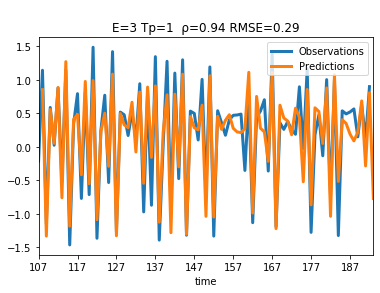

SMap( dataFrame = sampleData["circle"], lib = "1 100", pred = "110 190", theta = 4, E = 2, verbose = True, showPlot = True, embedded = True, columns = "x y", target = "x") 



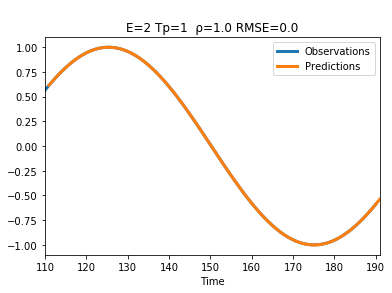

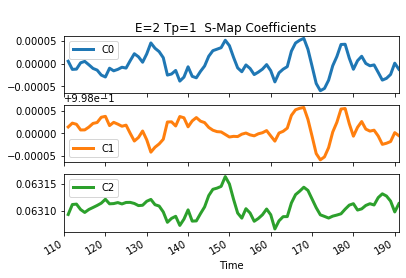

CCM( dataFrame = sampleData["sardine_anchovy_sst"], E = 3, Tp = 0, columns = "anchovy", target = "np_sst", libSizes = "10 70 10", sample = 100, verbose = True,  showPlot = True) 



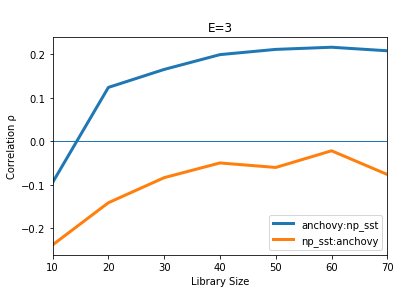

In [3]:
pyEDM.Examples()

# Load Data

In [6]:
#change automatic colors to cmap

n = 20
color = plt.cm.winter(np.linspace(0, 1,n))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

In [20]:
#Here is the main directory
OROMIA_TS_DIR = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/Final_TS/oromia_df_normalized/'
#save figures to this folder
FIGURES = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Figures/'
SMOOTHED_DIR = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/Final_TS/smoothed/'

#Directory for seasonal decomposed time series
OROMIA_TS_DS = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/Final_TS/oromia_df_seasonaldecomposed/'


In [21]:
#View time series data and insert columns: dekad, year, month
oromia_croplands_ts = pd.read_csv(OROMIA_TS_DIR + 'oromia_croplands_df_norm.csv',index_col=False)
oromia_croplands_ts.Time = pd.to_datetime(oromia_croplands_ts['Time'])
oromia_croplands_ts.insert(1, 'Dekad', pd.Series(list(range(19,37)) + list(range(1,37))*14))
oromia_croplands_ts['Year'], oromia_croplands_ts['Month'] = oromia_croplands_ts['Time'].dt.year, oromia_croplands_ts['Time'].dt.month


In [22]:
oromia_croplands_ts

,Time,Dekad,SM,TMP,P,LST,NDVI,refET,Year,Month
0,2002-07-01,19,0.135646,0.052480,0.742506,0.037586,-0.083077,0.056306,2002,7
1,2002-07-11,20,0.544381,-0.904232,0.831454,-0.684467,-0.026029,-0.777299,2002,7
2,2002-07-21,21,1.024050,-1.651244,2.282451,-0.969916,0.021414,-0.294196,2002,7
3,2002-08-01,22,1.238326,-1.839325,1.355295,-1.152511,0.281149,-1.135613,2002,8
4,2002-08-11,23,1.272390,-1.681766,1.303809,-1.152511,0.749501,-0.960297,2002,8
...,...,...,...,...,...,...,...,...,...,...
517,2016-11-11,32,-0.607893,-0.185363,-0.930699,-0.009177,0.314271,-0.206690,2016,11
518,2016-11-21,33,-0.689993,-0.117030,-0.758587,-0.407309,-0.025562,-1.129312,2016,11
519,2016-12-01,34,-0.820439,-0.639136,-0.966702,0.231113,-0.288986,-0.521770,2016,12
520,2016-12-11,35,-1.135127,-0.063027,-0.979032,0.386684,-0.505438,-0.371977,2016,12


In [23]:
oromia_croplands_years = oromia_croplands_ts.groupby('Year')

# Explore Time Series Delays

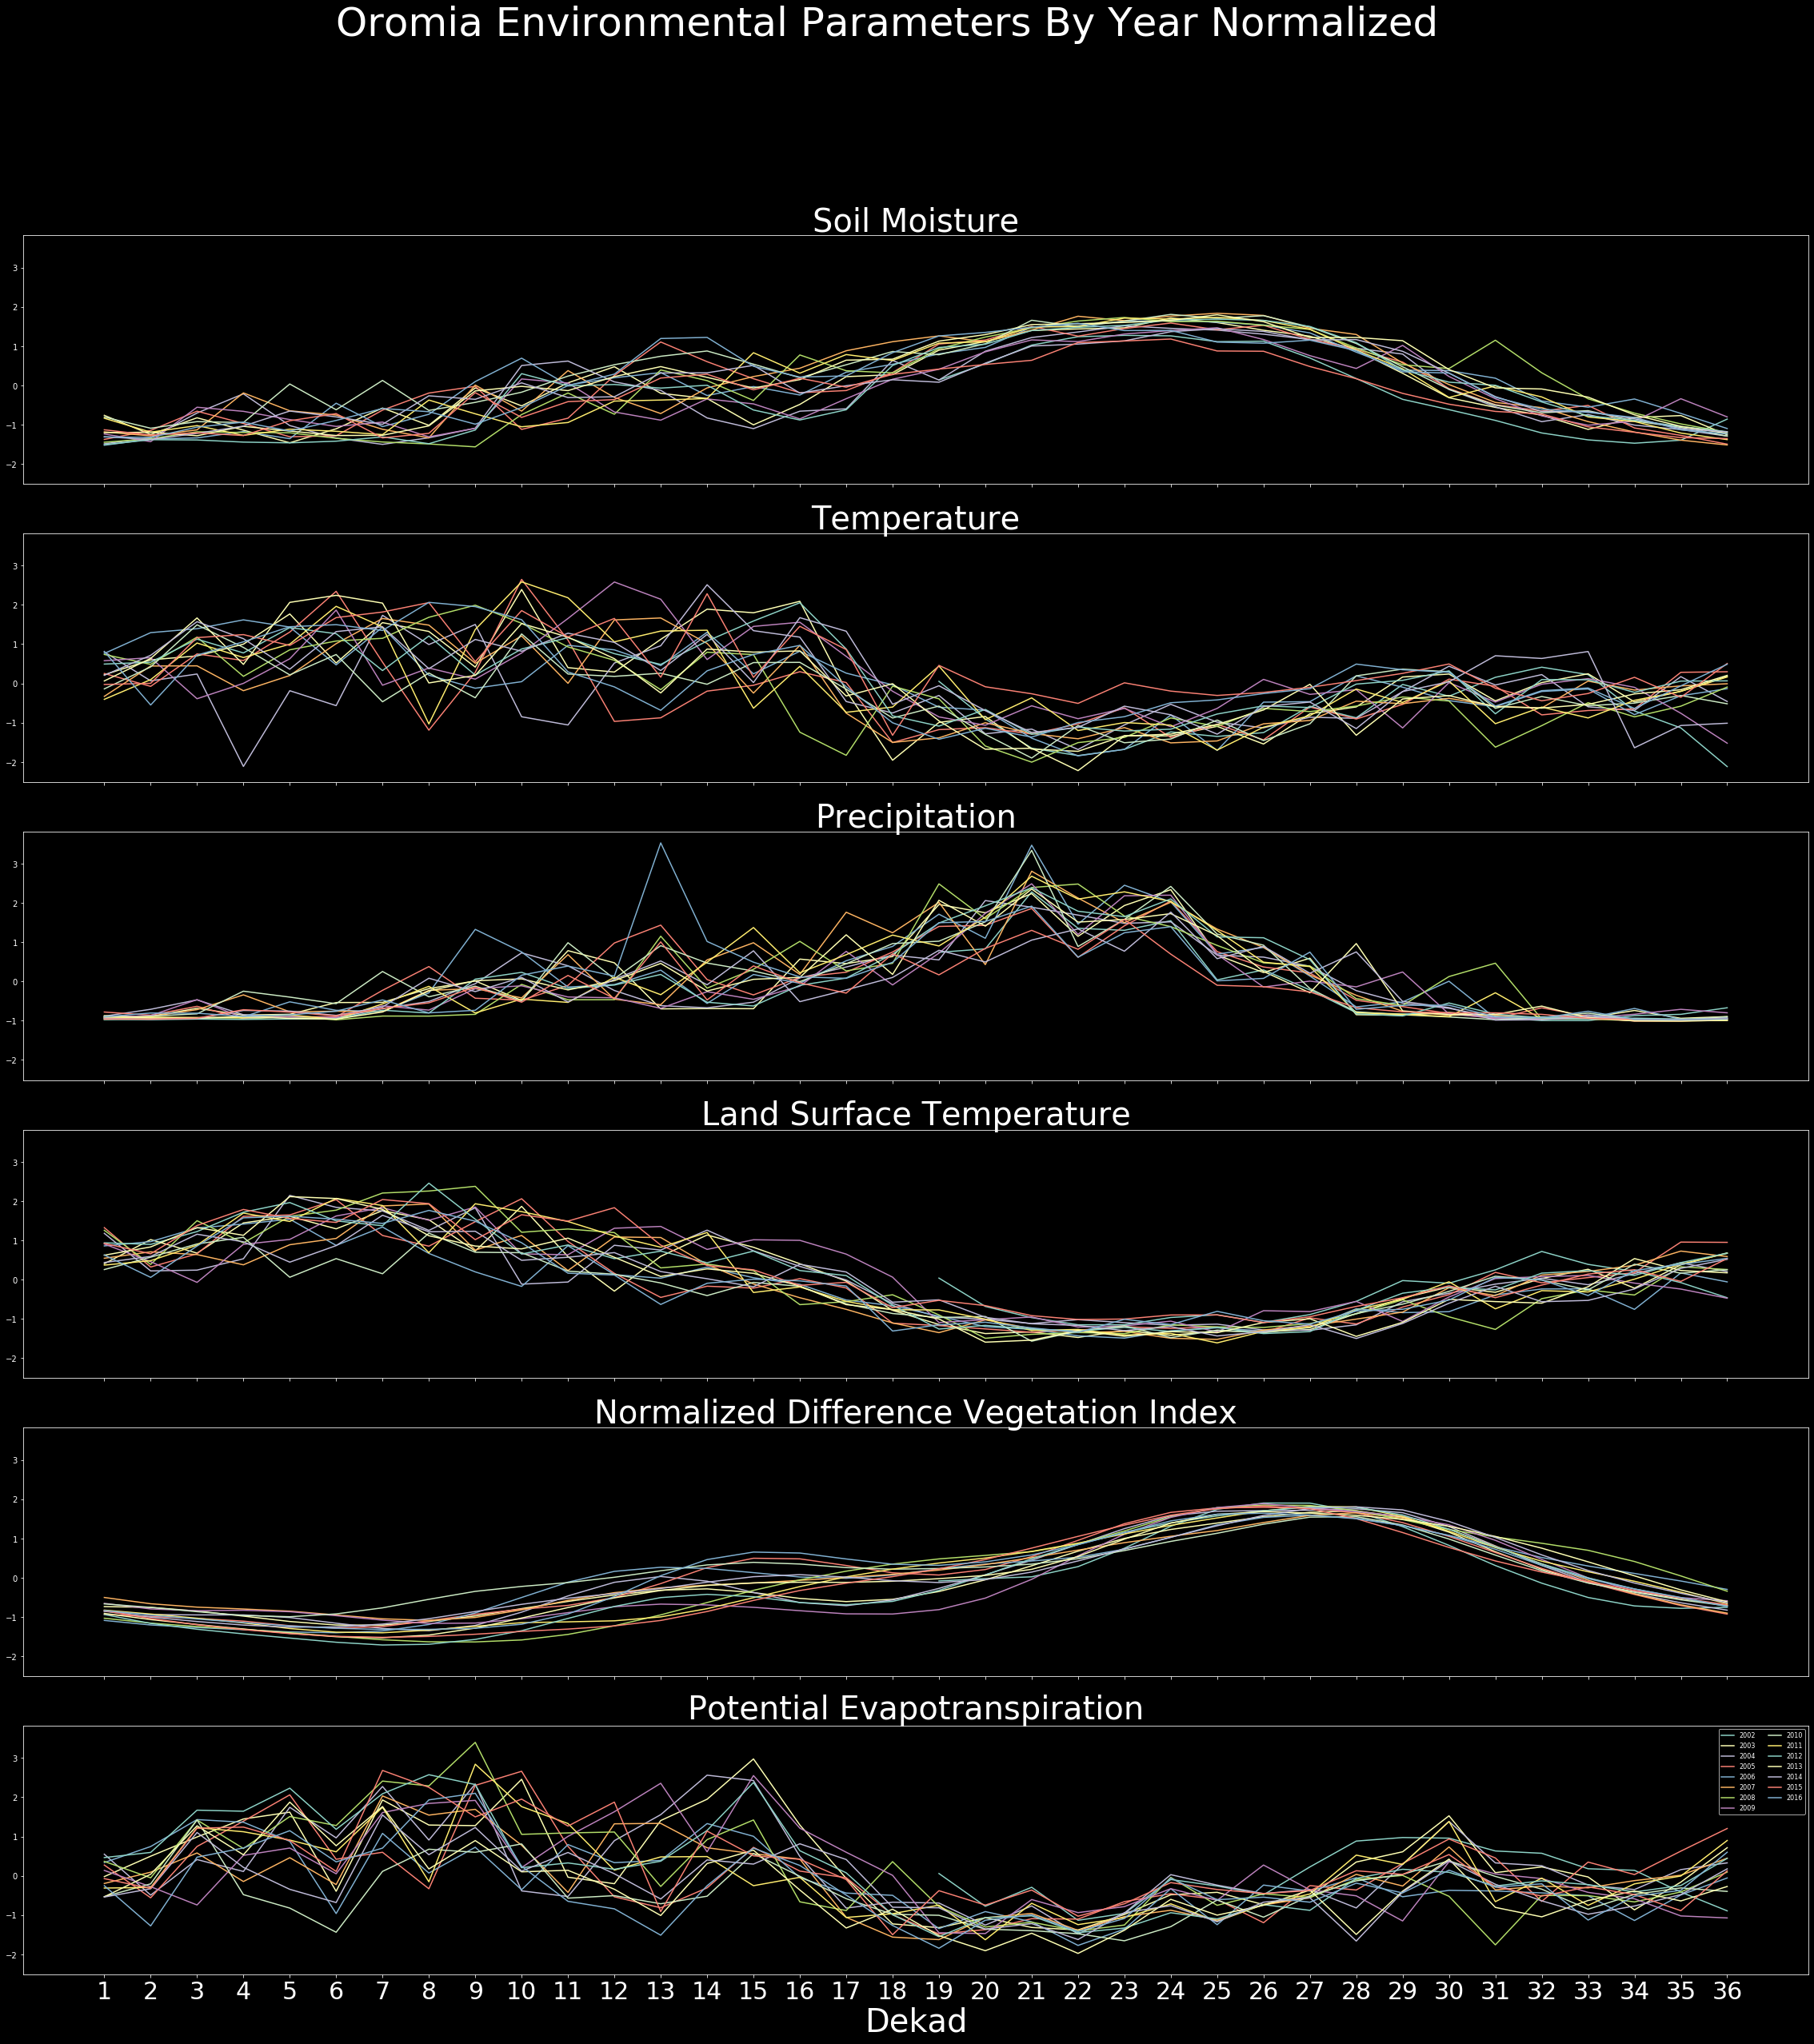

In [24]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(6,sharex=True,sharey=True,figsize=(40,40))
for label, df in oromia_croplands_years:
    year_group = oromia_croplands_years.get_group(label)
    ax1.plot(oromia_croplands_years.get_group(label).Dekad, oromia_croplands_years.get_group(label).SM, label = label)
    ax1.set_title('Soil Moisture', fontsize = 40)
    #ax1.legend(loc = 'upper right', ncol = 2, fontsize = 8)
    ax2.plot(oromia_croplands_years.get_group(label).Dekad, oromia_croplands_years.get_group(label).TMP, label = label)
    ax2.set_title('Temperature', fontsize = 40)
    ax3.plot(oromia_croplands_years.get_group(label).Dekad, oromia_croplands_years.get_group(label).P, label = label)
    ax3.set_title('Precipitation', fontsize = 40)
    ax4.plot(oromia_croplands_years.get_group(label).Dekad, oromia_croplands_years.get_group(label).LST, label = label)
    ax4.set_title('Land Surface Temperature', fontsize = 40)
    ax5.plot(oromia_croplands_years.get_group(label).Dekad, oromia_croplands_years.get_group(label).NDVI, label = label)
    ax5.set_title('Normalized Difference Vegetation Index', fontsize = 40)
    ax6.plot(oromia_croplands_years.get_group(label).Dekad, oromia_croplands_years.get_group(label).refET, label = label)
    ax6.set_title('Potential Evapotranspiration', fontsize = 40)
        
plt.xticks(np.arange(1,37,1), fontsize = 30)
#fig.yticks(fontsize = 30)
plt.xlabel('Dekad', fontsize = 40)
fig.suptitle('Oromia Environmental Parameters By Year Normalized', fontsize = 50)
legend = plt.legend(loc = 'upper right', ncol = 2, fontsize = 8)
#plt.gca().set_axis_off()
#plt.subplots_adjust(hspace=0.3)

#fig.savefig(FIGURES + 'oromia_parameters_by_dekad.pdf', bbox_inches='tight')

In [25]:
#save legend as separate image for presentation
def export_legend(legend, filename= FIGURES + 'oromia_parameters_by_dekad_legend.png', expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend)
plt.show()

In [26]:
oromia_croplands_dekads_mean = oromia_croplands_ts.groupby('Dekad').mean()

In [27]:
oromia_croplands_dekads_std = oromia_croplands_ts.groupby('Dekad').std()

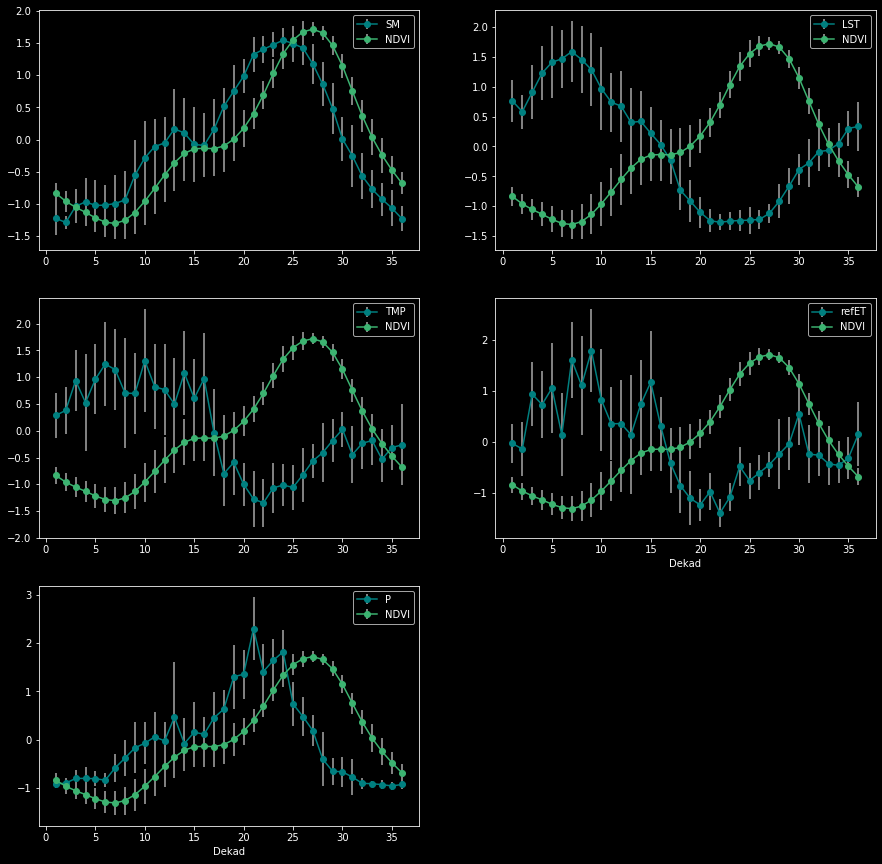

In [28]:
fig, axs = plt.subplots(3,2, figsize = (15,15))
axs[0,0].errorbar(oromia_croplands_dekads_mean.index, oromia_croplands_dekads_mean.SM, oromia_croplands_dekads_std.SM, fmt='-o', color = 'teal', label = 'SM', ecolor = 'gray', elinewidth=2)
axs[0,0].errorbar(oromia_croplands_dekads_mean.index, oromia_croplands_dekads_mean.NDVI, oromia_croplands_dekads_std.NDVI, fmt='-o', color = 'mediumseagreen', label = 'NDVI', ecolor = 'gray', elinewidth=2)
axs[0,0].legend()
axs[1,0].errorbar(oromia_croplands_dekads_mean.index, oromia_croplands_dekads_mean.TMP, oromia_croplands_dekads_std.TMP, fmt='-o', color = 'teal', label = 'TMP', ecolor = 'gray', elinewidth=2)
axs[1,0].errorbar(oromia_croplands_dekads_mean.index, oromia_croplands_dekads_mean.NDVI, oromia_croplands_dekads_std.NDVI, fmt='-o', color = 'mediumseagreen', label = 'NDVI', ecolor = 'gray', elinewidth=2)
axs[1,0].legend()
axs[2,0].errorbar(oromia_croplands_dekads_mean.index, oromia_croplands_dekads_mean.P, oromia_croplands_dekads_std.P, fmt='-o', color = 'teal', label = 'P', ecolor = 'gray', elinewidth=2)
axs[2,0].errorbar(oromia_croplands_dekads_mean.index, oromia_croplands_dekads_mean.NDVI, oromia_croplands_dekads_std.NDVI, fmt='-o', color = 'mediumseagreen', label = 'NDVI', ecolor = 'gray', elinewidth=2)
axs[2,0].legend()
axs[0,1].errorbar(oromia_croplands_dekads_mean.index, oromia_croplands_dekads_mean.LST, oromia_croplands_dekads_std.LST, fmt='-o', color = 'teal', label = 'LST', ecolor = 'gray', elinewidth=2)
axs[0,1].errorbar(oromia_croplands_dekads_mean.index, oromia_croplands_dekads_mean.NDVI, oromia_croplands_dekads_std.NDVI, fmt='-o', color = 'mediumseagreen', label = 'NDVI', ecolor = 'gray', elinewidth=2)
axs[0,1].legend()
axs[1,1].errorbar(oromia_croplands_dekads_mean.index, oromia_croplands_dekads_mean.refET, oromia_croplands_dekads_std.refET, fmt='-o', color = 'teal', label = 'refET', ecolor = 'gray', elinewidth=2)
axs[1,1].errorbar(oromia_croplands_dekads_mean.index, oromia_croplands_dekads_mean.NDVI, oromia_croplands_dekads_std.NDVI, fmt='-o', color = 'mediumseagreen', label = 'NDVI', ecolor = 'gray', elinewidth=2)
axs[1,1].legend()
axs[1,1].set_xlabel('Dekad')
axs[2,0].set_xlabel('Dekad')
fig.delaxes(axs[2,1])

fig.savefig(FIGURES + 'oromia_parameter_vs_ndvi_by_dekad.pdf', bbox_inches='tight')


# Plot attractor reconstructions

In [29]:
oromia_croplands_embed_sm = Embed(pathIn = SMOOTHED_DIR, dataFile = 'oromia_croplands_smoothed.csv', E = 3, tau = 1, columns = 'SM')

oromia_croplands_embed_ndvi = Embed(pathIn = SMOOTHED_DIR, dataFile = 'oromia_croplands_smoothed.csv', E = 3, tau = 1, columns = 'NDVI')

oromia_croplands_embed_p = Embed(pathIn = SMOOTHED_DIR, dataFile = 'oromia_croplands_smoothed.csv', E = 3, tau = 1, columns = 'P')

oromia_croplands_embed_refET = Embed(pathIn = SMOOTHED_DIR, dataFile = 'oromia_croplands_smoothed.csv', E = 3, tau = 1, columns = 'refET')

oromia_croplands_embed_lst = Embed(pathIn = SMOOTHED_DIR, dataFile = 'oromia_croplands_smoothed.csv', E = 3, tau = 1, columns = 'LST')

oromia_croplands_embed_tmp = Embed(pathIn = SMOOTHED_DIR, dataFile = 'oromia_croplands_smoothed.csv', E = 3, tau = 1, columns = 'TMP')


In [33]:
oromia_croplands_embed_sm

,SM(t+0),SM(t+1),SM(t+2)
0,0.435909,0.619961,0.788541
1,0.619961,0.788541,0.946293
2,0.788541,0.946293,1.097576
3,0.946293,1.097576,1.109198
4,1.097576,1.109198,0.997520
...,...,...,...
515,0.141658,-0.145665,-0.416669
516,-0.145665,-0.416669,-0.648650
517,-0.416669,-0.648650,-0.876097
518,-0.648650,-0.876097,-1.097517


In [36]:
oromia_croplands_embed_ndvi = Embed(pathIn = SMOOTHED_DIR, dataFile = 'oromia_croplands_smoothed.csv', E = 8, columns = 'NDVI')


In [37]:
oromia_croplands_embed_ndvi.head(20)

,NDVI(t-0),NDVI(t-1),NDVI(t-2),NDVI(t-3),NDVI(t-4),NDVI(t-5),NDVI(t-6),NDVI(t-7)
0,1.901580,1.741075,1.309556,0.749501,0.281149,0.021414,-0.026029,-0.083077
1,1.899045,1.901580,1.741075,1.309556,0.749501,0.281149,0.021414,-0.026029
2,1.682296,1.899045,1.901580,1.741075,1.309556,0.749501,0.281149,0.021414
3,1.299461,1.682296,1.899045,1.901580,1.741075,1.309556,0.749501,0.281149
4,0.822474,1.299461,1.682296,1.899045,1.901580,1.741075,1.309556,0.749501
5,0.309153,0.822474,1.299461,1.682296,1.899045,1.901580,1.741075,1.309556
6,-0.140475,0.309153,0.822474,1.299461,1.682296,1.899045,1.901580,1.741075
7,-0.505480,-0.140475,0.309153,0.822474,1.299461,1.682296,1.899045,1.901580
8,-0.720602,-0.505480,-0.140475,0.309153,0.822474,1.299461,1.682296,1.899045
9,-0.781452,-0.720602,-0.505480,-0.140475,0.309153,0.822474,1.299461,1.682296


Text(0, 0.5, 'Precipitation')

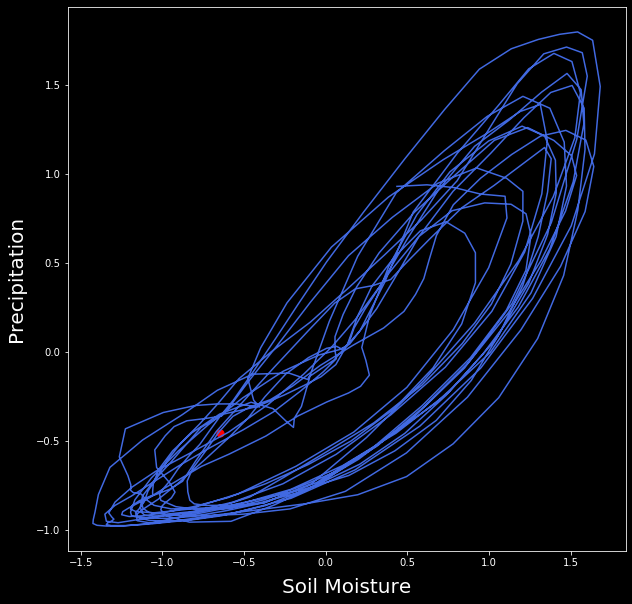

In [38]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(10,10))
ax = plt.axes()
ax.plot(oromia_croplands_embed_sm['SM(t+0)'], oromia_croplands_embed_p['P(t+0)'], c = 'royalblue')
ax.scatter(oromia_croplands_embed_sm['SM(t+0)'].iloc[25], oromia_croplands_embed_sm['SM(t+1)'].iloc[25], color = 'red', s = 50)
#ax.view_init(30,10)
#plt.savefig(FIGURES + 'sm_attractor_reconstruction.png', dpi=100)
ax.grid(False)
ax.set_xlabel('Soil Moisture', fontsize = 20, labelpad = 10)
ax.set_ylabel('Precipitation', fontsize = 20, labelpad = 10)
#ax.set_zlabel('Land Surface Temperature', fontsize = 20, labelpad = 10)
#plt.savefig(FIGURES + 'sm_p_2d_attractor_reconstruction.png', dpi=100)

Text(0.5, 0, 'Land Surface Temperature')

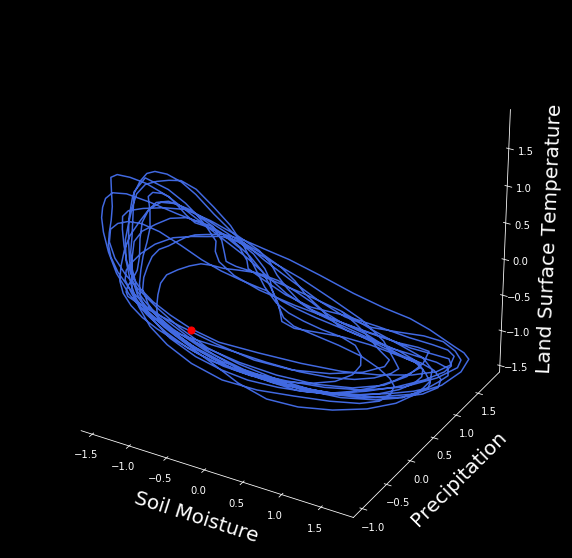

In [40]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot3D(oromia_croplands_embed_sm['SM(t+0)'], oromia_croplands_embed_p['P(t+0)'], oromia_croplands_embed_lst['LST(t+0)'], c = 'royalblue')
ax.scatter3D(oromia_croplands_embed_sm['SM(t+0)'].iloc[25], oromia_croplands_embed_sm['SM(t+1)'].iloc[25], oromia_croplands_embed_sm['SM(t+2)'].iloc[25], color = 'red', s = 50)
#ax.view_init(30,10)
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.set_xlabel('Soil Moisture', fontsize = 20, labelpad = 10)
ax.set_ylabel('Precipitation', fontsize = 20, labelpad = 10)
ax.set_zlabel('Land Surface Temperature', fontsize = 20, labelpad = 10)

#plt.savefig(FIGURES + 'sm_p_lst_attractor_reconstruction.png', dpi=100)


In [ ]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot3D(oromia_croplands_embed_sm['SM(t-0)'], oromia_croplands_embed_sm['SM(t-1)'], oromia_croplands_embed_sm['SM(t-2)'], c = 'royalblue')
ax.scatter3D(oromia_croplands_embed_sm['SM(t-0)'].iloc[25], oromia_croplands_embed_sm['SM(t-1)'].iloc[25], oromia_croplands_embed_sm['SM(t-2)'].iloc[25], color = 'red', s = 50)
#ax.view_init(30,10)
plt.savefig(FIGURES + 'sm_attractor_reconstruction.png', dpi=100)
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.set_xlabel('Soil Moisture(t-0)', fontsize = 20, labelpad = 10)
ax.set_ylabel('Soil Moisture(t-1)', fontsize = 20, labelpad = 10)
ax.set_zlabel('Soil Moisture(t-2)', fontsize = 20, labelpad = 10)
plt.savefig(FIGURES + 'sm_attractor_reconstruction.png', dpi=100)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot3D(oromia_croplands_embed_p['P(t-0)'], oromia_croplands_embed_p['P(t-1)'], oromia_croplands_embed_p['P(t-2)'], c = 'royalblue')
ax.scatter3D(oromia_croplands_embed_p['P(t-0)'].iloc[25], oromia_croplands_embed_p['P(t-1)'].iloc[25], oromia_croplands_embed_p['P(t-2)'].iloc[25], color = 'red', s = 50)
#ax.view_init(30,10)
plt.savefig(FIGURES + 'sm_attractor_reconstruction.png', dpi=100)
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.set_xlabel('Precipitation(t-0)', fontsize = 20, labelpad = 10)
ax.set_ylabel('Precipitation(t-1)', fontsize = 20, labelpad = 10)
ax.set_zlabel('Precipitation(t-2)', fontsize = 20, labelpad = 10)
plt.savefig(FIGURES + 'precip_attractor_reconstruction.png', dpi=100)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot3D(oromia_croplands_embed_tmp['TMP(t-0)'], oromia_croplands_embed_tmp['TMP(t-1)'], oromia_croplands_embed_tmp['TMP(t-2)'], c = 'royalblue')
ax.scatter3D(oromia_croplands_embed_tmp['TMP(t-0)'].iloc[25], oromia_croplands_embed_tmp['TMP(t-1)'].iloc[25], oromia_croplands_embed_tmp['TMP(t-2)'].iloc[25], color = 'red', s = 50)
#ax.view_init(30,10)
plt.savefig(FIGURES + 'sm_attractor_reconstruction.png', dpi=100)
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.set_xlabel('Temperature(t-0)', fontsize = 20, labelpad = 10)
ax.set_ylabel('Temperature(t-1)', fontsize = 20, labelpad = 10)
ax.set_zlabel('Temperature(t-2)', fontsize = 20, labelpad = 10)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot3D(oromia_croplands_embed_ndvi['NDVI(t-0)'], oromia_croplands_embed_ndvi['NDVI(t-1)'], oromia_croplands_embed_ndvi['NDVI(t-2)'], c = 'royalblue')
#ax.scatter3D(oromia_croplands_embed_sm['SM(t-0)'], oromia_croplands_embed_sm['SM(t-1)'], oromia_croplands_embed_sm['SM(t-2)'])
ax.scatter3D(oromia_croplands_embed_ndvi['NDVI(t-0)'].iloc[25], oromia_croplands_embed_ndvi['NDVI(t-1)'].iloc[25], oromia_croplands_embed_ndvi['NDVI(t-2)'].iloc[25], color = 'red', s = 50)
#ax.view_init(30,10)
#plt.suptitle('NDVI Attractor Reconstruction', y = 0.9)
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.set_xlabel('NDVI(t-0)', fontsize = 20, labelpad = 10)
ax.set_ylabel('NDVI(t-1)', fontsize = 20, labelpad = 10)
ax.set_zlabel('NDVI(t-2)', fontsize = 20, labelpad = 10)
plt.savefig(FIGURES + 'ndvi_attractor_reconstruction.png', dpi=100)

# 1) find optimal embedding dimension
## specify library and prediction size, columns and target

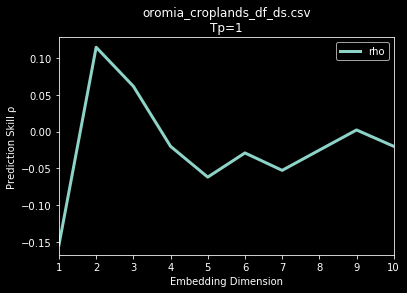

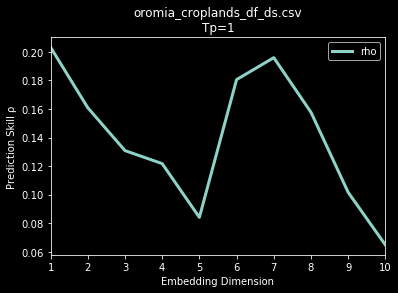

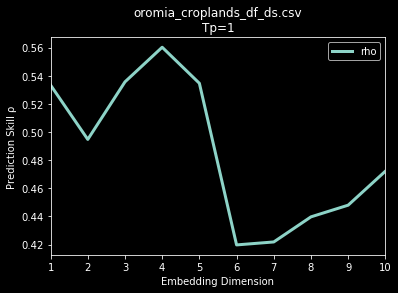

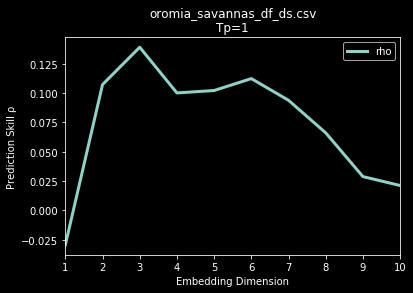

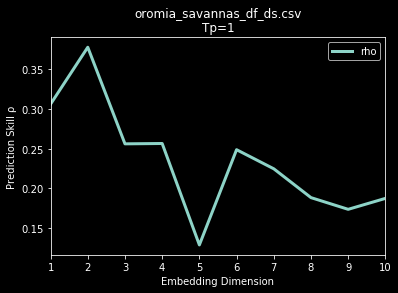

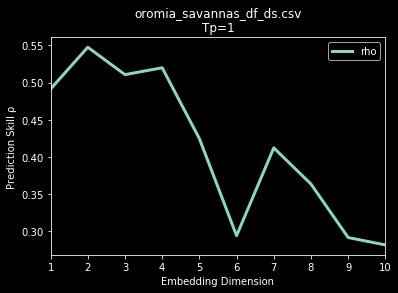

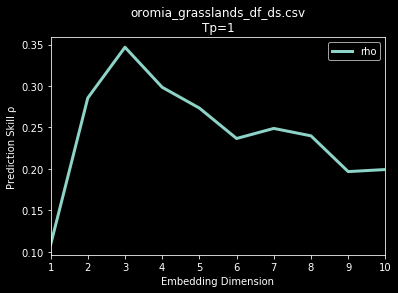

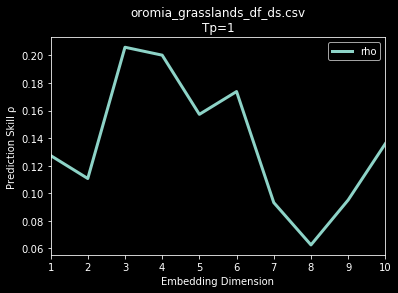

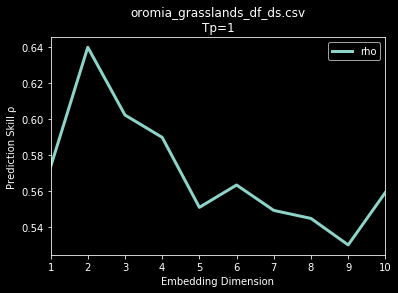

In [21]:
#embedding dimension with seasonal decomposed data
oromia_cropland_ds_ed_ndvi = EmbedDimension(pathIn = OROMIA_TS_DS, dataFile = 'oromia_croplands_df_ds.csv', lib = '1 100', pred = '101 400', columns = 'NDVI', showPlot = True)

oromia_cropland_ds_ed_sm = EmbedDimension(pathIn = OROMIA_TS_DS, dataFile = 'oromia_croplands_df_ds.csv', lib = '1 100', pred = '101 400', columns = 'SM', showPlot = True)

oromia_cropland_ds_ed_p = EmbedDimension(pathIn = OROMIA_TS_DS, dataFile = 'oromia_croplands_df_ds.csv', lib = '1 100', pred = '101 400', columns = 'P', showPlot = True)

oromia_savannas_ds_ed_ndvi = EmbedDimension(pathIn = OROMIA_TS_DS, dataFile = 'oromia_savannas_df_ds.csv', lib = '1 100', pred = '101 400', columns = 'NDVI', showPlot = True)

oromia_savannas_ds_ed_sm = EmbedDimension(pathIn = OROMIA_TS_DS, dataFile = 'oromia_savannas_df_ds.csv', lib = '1 100', pred = '101 400', columns = 'SM', showPlot = True)

oromia_savannas_ds_ed_p = EmbedDimension(pathIn = OROMIA_TS_DS, dataFile = 'oromia_savannas_df_ds.csv', lib = '1 100', pred = '101 400', columns = 'P', showPlot = True)

oromia_grasslands_ds_ed_ndvi = EmbedDimension(pathIn = OROMIA_TS_DS, dataFile = 'oromia_grasslands_df_ds.csv', lib = '1 100', pred = '101 400', columns = 'NDVI', showPlot = True)

oromia_grasslands_ds_ed_sm = EmbedDimension(pathIn = OROMIA_TS_DS, dataFile = 'oromia_grasslands_df_ds.csv', lib = '1 100', pred = '101 400', columns = 'SM', showPlot = True)

oromia_grasslands_ds_ed_p = EmbedDimension(pathIn = OROMIA_TS_DS, dataFile = 'oromia_grasslands_df_ds.csv', lib = '1 100', pred = '101 400', columns = 'P', showPlot = True)



In [22]:
oromia_cropland_ds_ed_ndvi

,E,rho
0,1.0,-0.154250
1,2.0,0.114651
2,3.0,0.061593
3,4.0,-0.020150
4,5.0,-0.062015
5,6.0,-0.029121
6,7.0,-0.052830
7,8.0,-0.025302
8,9.0,0.002114
9,10.0,-0.020134


In [ ]:
oromia_barren_ed_sm = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_barren_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'SM', showPlot = True)
oromia_barren_ed_tmp = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_barren_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'TMP', showPlot = False)
oromia_barren_ed_p = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_barren_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'P', showPlot = False)
oromia_barren_ed_lst = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_barren_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'LST', showPlot = False)
oromia_barren_ed_ndvi = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_barren_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'NDVI', showPlot = False)
oromia_barren_ed_refET = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_barren_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'refET', showPlot = False)


In [ ]:
oromia_closedshrublands_ed_sm = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_closedshrublands_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'SM', showPlot = False)
oromia_closedshrublands_ed_tmp = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_closedshrublands_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'TMP', showPlot = True)
oromia_closedshrublands_ed_p = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_closedshrublands_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'P', showPlot = False)
oromia_closedshrublands_ed_lst = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_closedshrublands_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'LST', showPlot = False)
oromia_closedshrublands_ed_ndvi = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_closedshrublands_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'NDVI', showPlot = False)
oromia_closedshrublands_ed_refET = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_closedshrublands_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'refET', showPlot = False)

In [ ]:
oromia_cropland_ed_sm = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_croplands_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'SM', showPlot = False)
oromia_cropland_ed_tmp = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_croplands_df_normalized.csv', lib = '1 100', pred = '101 500', tau = 2, columns = 'TMP', showPlot = True)
oromia_cropland_ed_p = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_croplands_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'P', showPlot = False)
oromia_cropland_ed_lst = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_croplands_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'LST', showPlot = False)
oromia_cropland_ed_ndvi = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_croplands_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'NDVI', showPlot = True)
oromia_cropland_ed_refET = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_croplands_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'refET', showPlot = False)


In [ ]:
oromia_cropnatveg_ed_sm = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_cropnatveg_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'SM', showPlot = False)
oromia_cropnatveg_ed_tmp = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_cropnatveg_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'TMP', showPlot = False)
oromia_cropnatveg_ed_p = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_cropnatveg_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'P', showPlot = False)
oromia_cropnatveg_ed_lst = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_cropnatveg_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'LST', showPlot = False)
oromia_cropnatveg_ed_ndvi = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_cropnatveg_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'NDVI', showPlot = False)
oromia_cropnatveg_ed_refET = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_cropnatveg_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'refET', showPlot = False)

In [ ]:
oromia_deciduousbroad_ed_sm = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_deciduousbroad_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'SM', showPlot = False)
oromia_deciduousbroad_ed_tmp = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_deciduousbroad_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'TMP', showPlot = False)
oromia_deciduousbroad_ed_p = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_deciduousbroad_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'P', showPlot = False)
oromia_deciduousbroad_ed_lst = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_deciduousbroad_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'LST', showPlot = False)
oromia_deciduousbroad_ed_ndvi = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_deciduousbroad_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'NDVI', showPlot = False)
oromia_deciduousbroad_ed_refET = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_deciduousbroad_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'refET', showPlot = False)

In [ ]:
oromia_evergreenbroad_ed_sm = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_evergreenbroad_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'SM', showPlot = False)
oromia_evergreenbroad_ed_tmp = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_evergreenbroad_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'TMP', showPlot = False)
oromia_evergreenbroad_ed_p = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_evergreenbroad_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'P', showPlot = False)
oromia_evergreenbroad_ed_lst = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_evergreenbroad_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'LST', showPlot = False)
oromia_evergreenbroad_ed_ndvi = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_evergreenbroad_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'NDVI', showPlot = False)
oromia_evergreenbroad_ed_refET = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_evergreenbroad_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'refET', showPlot = False)

In [ ]:
oromia_grasslands_ed_sm = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_grasslands_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'SM', showPlot = False)
oromia_grasslands_ed_tmp = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_grasslands_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'TMP', showPlot = True)
oromia_grasslands_ed_p = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_grasslands_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'P', showPlot = False)
oromia_grasslands_ed_lst = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_grasslands_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'LST', showPlot = False)
oromia_grasslands_ed_ndvi = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_grasslands_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'NDVI', showPlot = False)
oromia_grasslands_ed_refET = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_grasslands_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'refET', showPlot = False)

In [ ]:
oromia_savannas_ed_sm = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_savannas_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'SM', tau = 2, Tp = 2, showPlot = False)
oromia_savannas_ed_tmp = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_savannas_df_normalized.csv', lib = '1 100', pred = '101 500', tau = 2, columns = 'TMP', showPlot = False)
oromia_savannas_ed_p = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_savannas_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'P', showPlot = True)
oromia_savannas_ed_lst = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_savannas_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'LST', showPlot = False)
oromia_savannas_ed_ndvi = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_savannas_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'NDVI', showPlot = False)
oromia_savannas_ed_refET = EmbedDimension(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_savannas_df_normalized.csv', lib = '1 100', pred = '101 500', columns = 'refET', showPlot = False)

In [ ]:
#find max rho and E 
#must change variables twice 

oromia_grasslands_ed_ndvi.iloc[oromia_grasslands_ed_ndvi['rho'].idxmax()]

#get just the E value
#oromia_savannas_ed_refET.iloc[oromia_savannas_ed_refET['rho'].idxmax()]



In [ ]:
oromia_evergreenbroad_ed_sm

# 2) Predict Interval
Simplex prediction skill for forecast intervals

In [ ]:
df = PredictInterval(pathIn = OROMIA_TS_DS, dataFile = 'oromia_croplands_df_ds.csv', lib = "1 100", pred = '101 450', tau = 2, E = 8, columns = 'SM', showPlot = True)

df = PredictInterval(pathIn = OROMIA_TS_DS, dataFile = 'oromia_croplands_df_ds.csv', lib = "1 100", pred = '101 450', tau = 2, E = 10, columns = 'TMP', showPlot = True)

df = PredictInterval(pathIn = OROMIA_TS_DS, dataFile = 'oromia_croplands_df_ds.csv', lib = "1 100", pred = '101 450', E = 9, columns = 'P', showPlot = True)

df = PredictInterval(pathIn = OROMIA_TS_DS, dataFile = 'oromia_croplands_df_ds.csv', lib = "1 100", pred = '101 450', E = 8, columns = 'LST', showPlot = True)

df = PredictInterval(pathIn = OROMIA_TS_DS, dataFile = 'oromia_croplands_df_ds.csv', lib = "1 100", pred = '101 450', E = 10, columns = 'NDVI', showPlot = True)





In [ ]:
df = PredictInterval(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_croplands_df_normalized.csv', lib = "1 100", pred = '201 500', tau = 2, E = 8, columns = 'SM', showPlot = True)

df = PredictInterval(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_croplands_df_normalized.csv', lib = "1 100", pred = '201 500', tau = 2, E = 10, columns = 'TMP', showPlot = True)

df = PredictInterval(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_croplands_df_normalized.csv', lib = "1 100", pred = '201 500', E = 9, columns = 'P', showPlot = True)

df = PredictInterval(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_croplands_df_normalized.csv', lib = "1 100", pred = '201 500', E = 8, columns = 'LST', showPlot = True)

df = PredictInterval(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_croplands_df_normalized.csv', lib = "1 100", pred = '201 500', E = 2, columns = 'NDVI', showPlot = True)


In [ ]:
plt.style.use('dark_background')
fi_croplands_tmp = PredictInterval(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_croplands_df_normalized.csv', lib = "1 100", pred = '201 500', E = 10, tau = 2, columns = 'TMP', showPlot = True)
fig = plt.figure(figsize = (15,12))
ax = plt.axes()
plt.title('Predict Interval Croplands Temperature')
ax.plot(fi_croplands_tmp.Tp, fi_croplands_tmp.rho, linewidth = 6, label = 'rho')
plt.xticks(np.arange(min(fi_croplands_tmp.Tp), max(fi_croplands_tmp.Tp)+1, 1.0))
ax.set_ylabel('Prediction Skill ' r'$\rho$')
ax.set_xlabel('Forecast Interval (Dekads)')
plt.legend(loc = 'upper right')
plt.savefig(FIGURES + 'fi_croplands_right.png', dpi=100)

In [ ]:
fi_croplands_tmp

# 3) Predict Nonlinear
Evaluates Smap forecast skill

In [ ]:
df = PredictNonlinear(pathIn = OROMIA_TS_DS, dataFile = 'oromia_savannas_df_ds.csv', lib = "1 100", pred = '101 450', E = 10, columns = 'refET', showPlot = True)



In [ ]:
df = PredictNonlinear(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_croplands_df_normalized.csv', lib = "1 100", pred = '201 500', E = 10, columns = 'TMP', showPlot = True)



In [ ]:
df = PredictNonlinear(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_croplands_df_normalized.csv', lib = "1 100", pred = '201 500', E = 10, columns = 'P', showPlot = True)



# 4) Simplex Projection

In [ ]:
#reset colors
n = 5
color = plt.cm.Spectral(np.linspace(0, 1,n))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

comparing Barren simplex projection of SM from SM, NDVI from SM, NDVI from P, NDVI from SM and P, NDVI from NDVI

In [ ]:
simplex_croplands_sm_sm = Simplex(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_croplands_df_normalized.csv', lib = '1 100', pred = '101 500', E = 8, columns = 'SM', target = 'SM', showPlot = True)

simplex_croplands_sm_ndvi = Simplex(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_croplands_df_normalized.csv', lib = '1 100', pred = '101 500', E = 8, columns = 'SM', target = 'NDVI', showPlot = True)

simplex_croplands_p_ndvi = Simplex(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_croplands_df_normalized.csv', lib = '1 100', pred = '101 500', E = 8, columns = 'P', target = 'NDVI', showPlot = True)

simplex_croplands_sm_p_ndvi = Simplex(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_croplands_df_normalized.csv', lib = '1 100', pred = '101 500', E = 8, columns = 'SM P', target = 'NDVI', showPlot = True)

simplex_croplands_ndvi_ndvi = Simplex(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_croplands_df_normalized.csv', lib = '1 100', pred = '101 500', E = 2, columns = 'NDVI', target = 'NDVI', showPlot = True)


In [ ]:
#simplex croplands seasonal decomposed TS
simplex_croplands_ds_sm_sm = Simplex(pathIn = OROMIA_TS_DS, dataFile = 'oromia_croplands_df_ds.csv', lib = '1 100', pred = '101 400', E = 7, columns = 'SM', target = 'SM', showPlot = True)

simplex_croplands_ds_sm_ndvi = Simplex(pathIn = OROMIA_TS_DS, dataFile = 'oromia_croplands_df_ds.csv', lib = '1 100', pred = '101 400', E = 8, columns = 'SM', target = 'NDVI', showPlot = True)

simplex_croplands_ds_dsp_ndvi = Simplex(pathIn = OROMIA_TS_DS, dataFile = 'oromia_croplands_df_ds.csv', lib = '1 100', pred = '101 400', E = 8, columns = 'P', target = 'NDVI', showPlot = True)

simplex_croplands_ds_sm_p_ndvi = Simplex(pathIn = OROMIA_TS_DS, dataFile = 'oromia_croplands_df_ds.csv', lib = '1 100', pred = '101 400', E = 8, columns = 'SM P', target = 'NDVI', showPlot = True)

simplex_croplands_ds_ndvi_ndvi = Simplex(pathIn = OROMIA_TS_DS, dataFile = 'oromia_croplands_df_ds.csv', lib = '1 100', pred = '101 400', E = 10, columns = 'NDVI', target = 'NDVI', showPlot = True)

simplex_croplands_ds_tmp_ndvi = Simplex(pathIn = OROMIA_TS_DS, dataFile = 'oromia_croplands_df_ds.csv', lib = '1 100', pred = '101 400', E = 10, columns = 'TMP', target = 'NDVI', showPlot = True)


In [ ]:
def rmse(predictions, targets):

    differences = predictions - targets                       #the DIFFERENCEs.

    differences_squared = differences ** 2                    #the SQUAREs of ^

    mean_of_differences_squared = differences_squared.mean()  #the MEAN of ^

    rmse_val = np.sqrt(mean_of_differences_squared)           #ROOT of ^

    return rmse_val 

In [ ]:
rmse(simplex_croplands_sm_sm.Observations, simplex_croplands_sm_sm.Predictions)

In [ ]:
rmse(simplex_croplands_sm_ndvi.Observations, simplex_croplands_sm_ndvi.Predictions)

In [ ]:
spearmanr(simplex_croplands_sm_ndvi.Observations, simplex_croplands_sm_ndvi.Predictions, nan_policy = 'omit')

In [ ]:
#add year locator
simplex_savannas_sm_sm = Simplex(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_savannas_df_normalized.csv', lib = '1 100', pred = '101 500', E = 8, columns = 'SM', target = 'SM', showPlot = True)

simplex_savannas_sm_ndvi = Simplex(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_savannas_df_normalized.csv', lib = '1 100', pred = '101 500', E = 8, columns = 'SM', target = 'NDVI', showPlot = True)

simplex_savannas_p_ndvi = Simplex(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_savannas_df_normalized.csv', lib = '1 100', pred = '101 500', E = 8, columns = 'P', target = 'NDVI', showPlot = True)

simplex_savannas_sm_p_ndvi = Simplex(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_savannas_df_normalized.csv', lib = '1 100', pred = '101 500', E = 8, columns = 'SM P', target = 'NDVI', showPlot = True)

simplex_savannas_ndvi_ndvi = Simplex(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_savannas_df_normalized.csv', lib = '1 100', pred = '101 500', E = 2, columns = 'NDVI', target = 'NDVI', showPlot = True)


In [ ]:
#add year locator
simplex_grasslands_sm_sm = Simplex(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_grasslands_df_normalized.csv', lib = '1 100', pred = '101 500', E = 10, columns = 'SM', target = 'SM', showPlot = True)

simplex_grasslands_sm_ndvi = Simplex(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_grasslands_df_normalized.csv', lib = '1 100', pred = '101 500', E = 10, columns = 'SM', target = 'NDVI', showPlot = True)

simplex_grasslands_p_ndvi = Simplex(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_grasslands_df_normalized.csv', lib = '1 100', pred = '101 500', E = 2, columns = 'P', target = 'NDVI', showPlot = True)

simplex_grasslands_tmp_ndvi = Simplex(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_grasslands_df_normalized.csv', lib = '1 100', pred = '101 500', E = 9, columns = 'TMP', target = 'NDVI', showPlot = True)

simplex_grasslands_sm_p_ndvi = Simplex(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_grasslands_df_normalized.csv', lib = '1 100', pred = '101 500', E = 8, columns = 'SM P', target = 'NDVI', showPlot = True)

simplex_grasslands_ndvi_ndvi = Simplex(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_grasslands_df_normalized.csv', lib = '1 100', pred = '101 500', E = 2, columns = 'NDVI', target = 'NDVI', showPlot = True)


In [ ]:
plt.rcParams.update({'font.size': 22})

In [ ]:
#plt.style.use('dark_background')
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')


fig = plt.figure(figsize = (30,12))
ax = plt.axes()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
plt.title('Simplex Projection Croplands NDVI using Reconstructed NDVI Manifold')
ax.plot(pd.to_datetime(simplex_savannas_ndvi_ndvi.Time), simplex_savannas_ndvi_ndvi.Observations, linewidth = 6, label = 'Observations')
ax.plot(pd.to_datetime(simplex_savannas_ndvi_ndvi.Time), simplex_savannas_ndvi_ndvi.Predictions, linewidth = 6, label = 'Predictions')
plt.legend(loc = 'upper right')
fig.autofmt_xdate()
plt.savefig(FIGURES + 'ndvi_simplex_projection.png', dpi=100)

In [ ]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')


fig = plt.figure(figsize = (30,12))
ax = plt.axes()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
plt.title('Simplex Projection Croplands Soil Moisture using Reconstructed Soil Moisture Manifold')
ax.plot(pd.to_datetime(simplex_croplands_sm_sm.Time), simplex_croplands_sm_sm.Observations, linewidth = 6, label = 'Observations')
ax.plot(pd.to_datetime(simplex_croplands_sm_sm.Time), simplex_croplands_sm_sm.Predictions, linewidth = 6, label = 'Predictions')
plt.legend(loc = 'upper right')
fig.autofmt_xdate()
plt.savefig(FIGURES + 'sm_simplex_projection.png', dpi=100)

In [ ]:
pd.to_datetime(df.Time)

In [ ]:
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots()
ax.plot(pd.to_datetime(df.Time), df.Observations)
ax.plot(pd.to_datetime(df.Time), df.Predictions)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)

# datemin = np.datetime64(df['Time'][0], 'Y')
# datemax = np.datetime64(df['Time'][-1], 'Y') + np.timedelta64(1, 'Y')
# ax.set_xlim(datemin, datemax)

fig.autofmt_xdate()
plt.show()


In [ ]:
df = Embed(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_croplands_df_normalized.csv', E = 4, tau = 2, columns = 'P', verbose = True)

In [ ]:
oromia_croplands.head(10)

In [ ]:
df.head()

# 5) SMap

In [ ]:
df = SMap(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_savannas_df_normalized.csv', lib = '1 100', pred = '101 500', E = 2, theta = 6, columns = 'NDVI', target = 'NDVI', showPlot = True)


In [ ]:
df = SMap(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_savannas_df_normalized.csv', lib = '1 100', pred = '101 500', E = 8, theta = 6, columns = 'P SM', target = 'NDVI', showPlot = True)


# 6) CCM

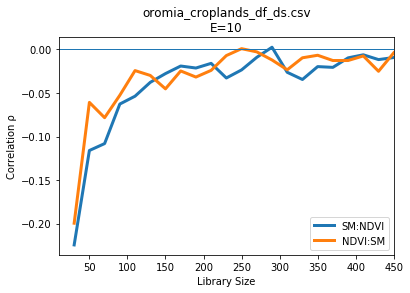

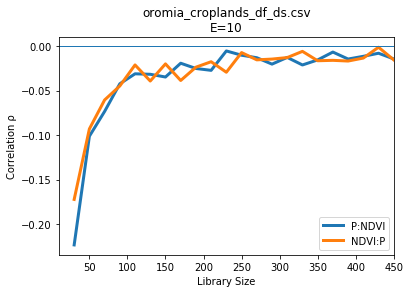

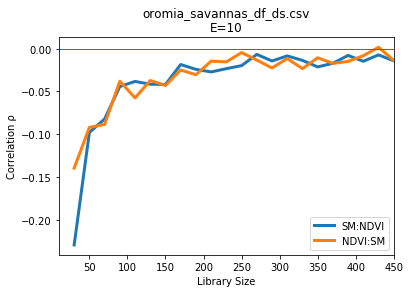

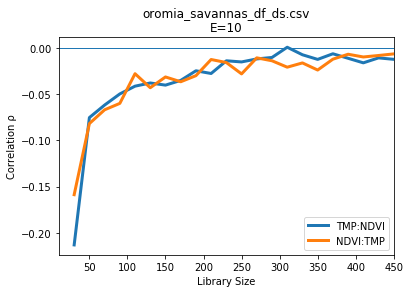

In [3]:
#seasonal decomposed TS
ccm_croplands_sm_ndvi_ds = CCM(pathIn = OROMIA_TS_DS, dataFile = 'oromia_croplands_df_ds.csv', E = 10, Tp = 2, tau = 1, columns = "SM", target = "NDVI", libSizes = "10 450 20", sample = 100, verbose = True,  showPlot = True) 
ccm_croplandsp_ndvi_ds = CCM(pathIn = OROMIA_TS_DS, dataFile = 'oromia_croplands_df_ds.csv', E = 10, Tp = 2, tau = 1, columns = "P", target = "NDVI", libSizes = "10 450 20", sample = 100, verbose = True,  showPlot = True) 
#seasonal decomposed TS
ccm_savannas_sm_ndvi_ds = CCM(pathIn = OROMIA_TS_DS, dataFile = 'oromia_savannas_df_ds.csv', E = 10, Tp = 2, tau = 1, columns = "SM", target = "NDVI", libSizes = "10 450 20", sample = 100, verbose = True,  showPlot = True) 
ccm_savannas_tmp_ndvi_ds = CCM(pathIn = OROMIA_TS_DS, dataFile = 'oromia_savannas_df_ds.csv', E = 10, Tp = 2, tau = 1, columns = "TMP", target = "NDVI", libSizes = "10 450 20", sample = 100, verbose = True,  showPlot = True) 




In [5]:
ccm_croplands_sm_ndvi_ds

,LibSize,SM:NDVI,NDVI:SM
0,10.0,NaN,NaN
1,30.0,-0.224524,-0.199595
2,50.0,-0.116065,-0.060777
3,70.0,-0.108124,-0.078366
4,90.0,-0.062691,-0.052615
5,110.0,-0.053671,-0.024261
6,130.0,-0.037770,-0.029833
7,150.0,-0.027712,-0.045230
8,170.0,-0.019023,-0.024682
9,190.0,-0.021316,-0.031691


In [4]:
ccm_sm_ndvi_ds

NameError: name 'ccm_sm_ndvi_ds' is not defined

In [ ]:
ccm = CCM(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_croplands_df_normalized.csv', E = 10, Tp = 0, tau = 2, columns = 'NDVI', target = "TMP", libSizes = "10 500 20", sample = 100, verbose = True,  showPlot = True) 




In [ ]:
ccm

In [ ]:
plt.rcParams.update({'font.size': 22})

In [ ]:
fig = plt.figure(figsize = (30,12))
ax = plt.axes()
plt.title('Convergent Cross Mapping NDVI vs Temperature')
ax.plot(ccm.LibSize, ccm['TMP:NDVI'], linewidth = 6, label = 'TMP xmap NDVI')
ax.plot(ccm.LibSize, ccm['NDVI:TMP'], linewidth = 6, label = 'NDVI xmap TMP')
ax.set_ylabel('Correlation ' r'$\rho$')
ax.set_xlabel('Library Length')
plt.legend(loc = 'lower right')
fig.autofmt_xdate()
plt.savefig(FIGURES + 'ccm_grasslands_ndvi_tmp.png', dpi=100)

In [ ]:
ccm_sm2 = CCM(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_evergreenbroad_df_normalized.csv', E = 10, Tp = 0, tau = 0, columns = "SM", target = "NDVI", libSizes = "10 500 20", sample = 100, verbose = True,  showPlot = True) 




In [ ]:
ccm_p = CCM(pathIn = OROMIA_TS_DIR, dataFile = 'oromia_evergreenbroad_df_normalized.csv', E = 10, Tp = 0, tau = 0, columns = "P", target = "NDVI", libSizes = "10 500 20", sample = 100, verbose = True,  showPlot = True) 




# 7) Multiview